In [1]:
import argparse
import sys
from torchvision.datasets import MNIST
from mynn.data import mnist_augment, preprocess, basic_mnist_augment, merge_datasets
from mynn.layer import Flatten, Linear, ReLU, He, Conv, Dropout, Pooling, BN,Sigmoid
from mynn.loss import CrossEntropy
from mynn import Model
from mynn.optimizer import SGD, Adam, MomentGD
from mynn.runner import RunnerM, EarlyStopping, CosineAnnealingLR
import cupy as cp

In [2]:
cp.random.seed(42)

train_dataset = MNIST(
        root="dataset",
        train=True,
        transform=basic_mnist_augment(train=True),
        download=True
    )
test_dataset = MNIST(
    root="dataset",
    train=False,
    transform=basic_mnist_augment(train=False),
    download=True
)

In [3]:
import numpy as np
train_images, train_labels = preprocess(train_dataset)
test_images,  test_labels  = preprocess(test_dataset)
# 
# train_images = train_images.astype(np.float32) / 255.0
# test_images = test_images.astype(np.float32) / 255.0

train_set = (train_images[:50000], train_labels[:50000])

dev_set   = (train_images[50000:], train_labels[50000:])
test_set  = (test_images, test_labels)

print("Min pixel value:", np.min(test_images))
print("Max pixel value:", np.max(test_images))

Min pixel value: 0.0
Max pixel value: 1.0


In [4]:
model = Model().load_model("best_model-lenet.pickle")
loss_fn = CrossEntropy(model=model)
runner = RunnerM(model=model, loss=loss_fn, optimizer=None)

test_loss, test_acc = runner.evaluate(test_set, batch_size=128)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

Model loaded from: best_model-lenet.pickle
Test loss: 0.0706, Test accuracy: 0.9776


In [5]:
from mynn.attack import bim_attack
adv_test_images = bim_attack(
    model=model, 
    images=test_images, 
    labels=test_labels, 
    loss_fn=loss_fn,
    epsilon=20/255,
    num_steps=10,
    step_size=4/255
)

test_set_adv = (adv_test_images, test_labels)

In [6]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=128)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 13.64665, Test accuracy: 0.00010


In [7]:
layers = [
    Conv(in_channel=1, out_channel=6, kernel=3, stride=1, padding=1, weight_decay=0.00),
    # BN(normalized_dims=(0, 2, 3), param_shape=(1, 32, 1, 1), weight_decay=0.001),
    Sigmoid(),
    Pooling(kernel=2),

    Conv(in_channel=6, out_channel=16, kernel=3, stride=1, padding=1, weight_decay=0.00),
    # BN(normalized_dims=(0, 2, 3), param_shape=(1, 64, 1, 1), weight_decay=0.001),
    Sigmoid(),
    Pooling(kernel=2),

    Flatten(),
    

    Linear(in_channel=16*7*7, out_channel=120, weight_decay=0.00),
    Linear(in_channel=120, out_channel=84, weight_decay=0.00),
    Linear(in_channel=84, out_channel=10, weight_decay=0.00),
]

In [8]:
model2 = Model(layers)
optimizer2 = Adam(model=model2, lr=0.001)
loss_fn2  = CrossEntropy(model=model2)
runner2  = RunnerM(model=model2, loss=loss_fn2, optimizer=optimizer2)

[Adversarial Train] Epoch 1/15: 100%|██████████| 391/391 [00:54<00:00,  7.16batch/s, accuracy=0.863, loss=0.4]  
train_loss: 0.26037, train_acc: 0.92310
dev_loss  : 0.22301, dev_acc  : 0.93809
### Best model saved to: best_models_lenet\2025-05-28_15-46-53\best_model.pickle
### Best validation accuracy updated: 0.00000 -> 0.93809
Patience Counter Reset to 0

[Adversarial Train] Epoch 2/15: 100%|██████████| 391/391 [01:07<00:00,  5.77batch/s, accuracy=0.95, loss=0.201] 
train_loss: 0.16033, train_acc: 0.95128
dev_loss  : 0.13940, dev_acc  : 0.96074
### Best model saved to: best_models_lenet\2025-05-28_15-46-53\best_model.pickle
### Best validation accuracy updated: 0.93809 -> 0.96074
Patience Counter Reset to 0

[Adversarial Train] Epoch 3/15: 100%|██████████| 391/391 [01:13<00:00,  5.29batch/s, accuracy=0.938, loss=0.268] 
train_loss: 0.11842, train_acc: 0.96509
dev_loss  : 0.10571, dev_acc  : 0.97090
### Best model saved to: best_models_lenet\2025-05-28_15-46-53\best_model.pickle
### B

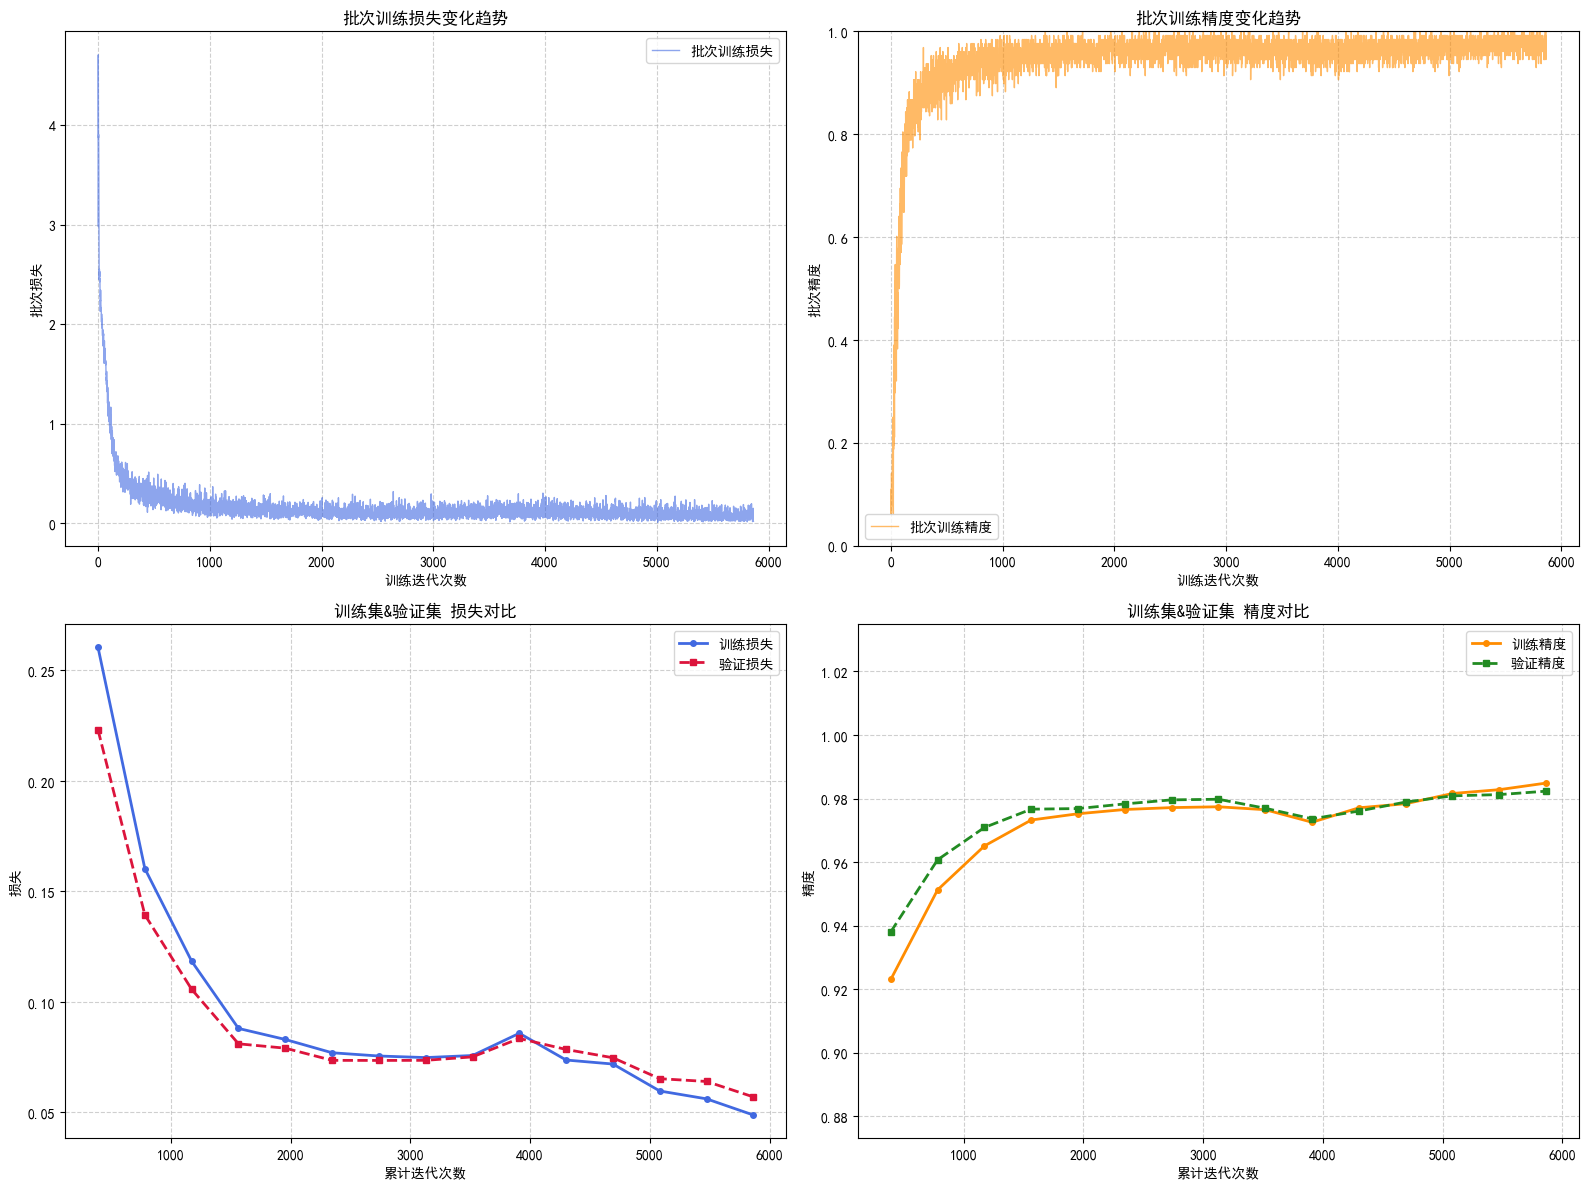

In [9]:
runner2.train_with_attack(
        train_set=train_set,
        dev_set=dev_set,
        batch_size=128,
        num_epochs=15,
        scheduler=CosineAnnealingLR(
            optimizer=optimizer2,
            T_max=5,
            eta_min=1e-5,
        ),
        strategy=EarlyStopping(
            patience=5,
            delta=0.0,
        ),
        shuffle=True,
        save_dir='best_models_lenet',
        attack_strategy='bim',
        epsilon=20/255,
        num_steps=10,
        step_size=4/255
    )

In [10]:
test_loss, test_acc = runner2.evaluate(test_set, batch_size=64)
print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.5f}")

Test loss: 0.05711, Test accuracy: 0.98248


In [11]:
from mynn.attack import bim_attack
adv_test_images = bim_attack(
    model=model2,
    images=test_images,
    labels=test_labels,
    loss_fn=loss_fn2,
    epsilon=20/255,
    num_steps=10,
    step_size=4/255,
)

test_set_adv = (adv_test_images, test_labels)
adv_loss, adv_acc = runner2.evaluate(test_set_adv, batch_size=128)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 8.93773, Test accuracy: 0.00435
